**Multi-Class ML-Based IDS**


Implemented a multi-class Network Intrusion Detection System using the NSL-KDD dataset. Attack traffic was categorized into DoS, Probe, R2L, and U2R classes. A Random Forest classifier was trained with proper preprocessing, feature scaling, and label encoding. Model performance was evaluated using confusion matrix, classification report, and ROC-AUC, with feature importance analysis for interpretability.

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
train_url = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.txt"
test_url  = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest+.txt"

train_df = pd.read_csv(train_url, header=None)
test_df  = pd.read_csv(test_url, header=None)

print(train_df.shape, test_df.shape)


(125973, 43) (22544, 43)


In [ ]:
columns = [
 'duration','protocol_type','service','flag','src_bytes','dst_bytes','land',
 'wrong_fragment','urgent','hot','num_failed_logins','logged_in','num_compromised',
 'root_shell','su_attempted','num_root','num_file_creations','num_shells',
 'num_access_files','num_outbound_cmds','is_host_login','is_guest_login',
 'count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate',
 'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count',
 'dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
 'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate',
 'label','difficulty'
]

train_df.columns = columns
test_df.columns  = columns


In [ ]:
attack_map = {
    'normal': 'Normal',
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'smurf': 'DoS', 'teardrop': 'DoS',
    'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe', 'satan': 'Probe',
    'ftp_write': 'R2L', 'guess_passwd': 'R2L', 'imap': 'R2L', 'multihop': 'R2L',
    'phf': 'R2L', 'spy': 'R2L', 'warezclient': 'R2L', 'warezmaster': 'R2L',
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R'
}

train_df['label'] = train_df['label'].map(attack_map)
test_df['label']  = test_df['label'].map(attack_map)


In [ ]:
train_df = train_df.dropna(subset=['label'])
test_df  = test_df.dropna(subset=['label'])

print(train_df['label'].value_counts())


label
Normal    67343
DoS       45726
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64


In [ ]:
label_encoder = LabelEncoder()

train_df['label'] = label_encoder.fit_transform(train_df['label'])
test_df['label']  = label_encoder.transform(test_df['label'])

print("Classes:", label_encoder.classes_)


Classes: ['DoS' 'Normal' 'Probe' 'R2L' 'U2R']


In [ ]:
X_train = train_df.drop(['label','difficulty'], axis=1)
y_train = train_df['label']

X_test  = test_df.drop(['label','difficulty'], axis=1)
y_test  = test_df['label']


In [ ]:
categorical_cols = ['protocol_type','service','flag']

for col in categorical_cols:
    encoder = LabelEncoder()
    X_train[col] = encoder.fit_transform(X_train[col])
    X_test[col]  = encoder.transform(X_test[col])


In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)


In [ ]:
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)


RandomForestClassifier(max_depth=20, n_jobs=-1, random_state=42)

In [ ]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

         DoS       0.99      0.99      0.99      5700
      Normal       0.81      0.97      0.88      9711
       Probe       0.84      1.00      0.91      1106
         R2L       1.00      0.01      0.02      2199
         U2R       1.00      0.03      0.05        37

    accuracy                           0.87     18753
   macro avg       0.93      0.60      0.57     18753
weighted avg       0.89      0.87      0.82     18753



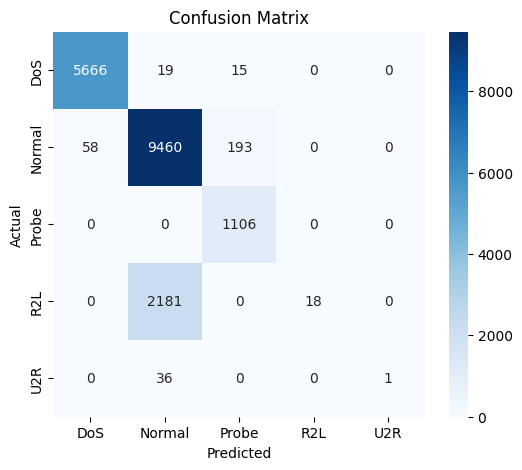

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
y_test_bin = label_binarize(y_test, classes=[0,1,2,3,4])
y_prob = model.predict_proba(X_test)

roc_auc = roc_auc_score(y_test_bin, y_prob, average='macro')
print("Macro ROC-AUC:", roc_auc)


Macro ROC-AUC: 0.9781819867786294


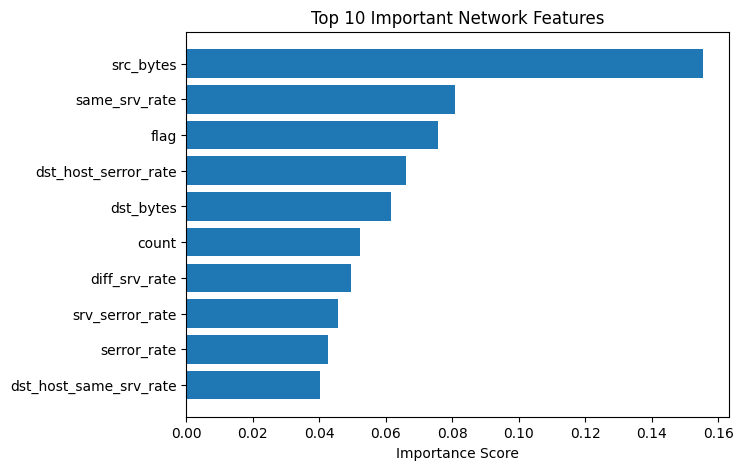

In [ ]:
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]

plt.figure(figsize=(7,5))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [columns[i] for i in indices])
plt.xlabel("Importance Score")
plt.title("Top 10 Important Network Features")
plt.show()
